# 2024 Winter Introduction to Deep Learning
### Based on Prof. Oh's Youtube Lecture
https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M

> Assignment #6


*   Youtube Lecture #23-26
*   Written by Seungeun Lee

## 1. Multi-class Classification w/ Custom ResNet model
*     Dataset: CIFAR10



*    Reference. https://github.com/Justin-A/DeepLearning101/blob/master/4-4_CIFAR_ResNet.ipynb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
# 런타임 - 런타임 유형 변경 - T4 GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.3.1+cu121  Device: cpu


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)


100%|██████████| 170498071/170498071 [00:03<00:00, 43611792.10it/s]


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


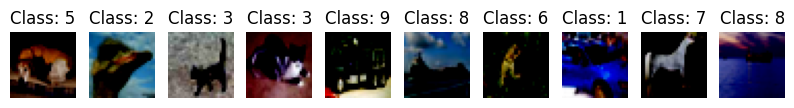

In [ ]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
## Question 1.
## Building custom ResNet model

class BasicBlock(nn.Module): # resnet에 있는 기본적인 구성 블럭을 만들기 위한 클래스
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False) # stride의 입력값에 따라 가로 세로의 크기를 조정해주고, 채널의 개수를 조정해줌.
        self.bn1 = nn.BatchNorm2d(planes) # 채널 개수를 입력으로 받아 batch normaliztion을 해줌.
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False) # kernel size=3, padding=1, stride=1을 통해서 가로 세로의 크기를 유지하고 채널의 개수도 유지함
        self.bn2 = nn.BatchNorm2d(planes) # 채널 개수를 입력으로 받아 batch normaliztion을 해줌.

        self.shortcut = nn.Sequential() # Resnet의 핵심인 shortcut을 적용하기 위해서 만든 신경망
        if stride != 1 or in_planes != planes: # 만약 stride !=1 이거나 채널의 개수가 맞지 않는 경우
            self.shortcut = nn.Sequential( # shortcut의 채널의 개수를 맞춰주는 역할을 한다.
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(planes))

    def forward(self, x): # 순전파 과정을 적용하는 함수
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # convolution 층을 지난 이후 shortcut을 더해줌.
        out = F.relu(out)
        return out

class ResNet(nn.Module): # Resnet 클래스 선언
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16 # 첫 신경망을 통과 한 후 BasicBlock에 들어갈 입력의 채널 수

        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False) #[32, 3, 32, 32] -> [32, 16, 32, 32]
        self.bn1 = nn.BatchNorm2d(16) # batch normaliztion 적용
        self.layer1 = self._make_layer(16, 2, stride = 1) # [32, 16, 32, 32] -> [32, 16, 32, 32]
        self.layer2 = self._make_layer(32, 2, stride = 2) # [32, 16, 32, 32] -> [32, 32, 16, 16]
        self.layer3 = self._make_layer(64, 2, stride = 2) # [32, 32, 16, 16] -> [32, 64, 8, 8]
        self.linear = nn.Linear(64, num_classes) # [32, 64] -> [32, 10]

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1)
        layers = []
        for stride in strides: #
            layers.append(BasicBlock(self.in_planes, planes, stride)) # layers 배열에 basic 블럭을 넣어줌
            self.in_planes = planes # 입력 채널의 수를 이전 레이어의 출력 채널의 수로 바꿔줌
        return nn.Sequential(*layers) # 구성한 layer을 신경망 형태로 반환

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8) # [32, 64, 8, 8] -> [32, 64, 1]
        out = out.view(out.size(0), -1) # [32, 64, 1] -> [32, 64]
        out = self.linear(out)
        return out

### Question 1. Explain the code above (building custom ResNet model) in detail -- line-by-line recommended

In [ ]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 1.328951
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.404933
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.177468
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.146765
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 0.834884
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.125883
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.689321
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.785508

[EPOCH: 1], 	Test Loss: 0.9347, 	Test Accuracy: 66.65 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.887890
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.711444
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.675358
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.995741
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.684251
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.664583
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.792905
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.632278

[EPOCH: 2], 	Test Loss: 0.8363, 	Test Accuracy: 71.08 % 

### The End.

##### Please upload your Colab file @Github https://github.com/duneag2/intro-dl/tree/main/Assignment6

*   First, make your folder by your name (e.g. seungeun)
*   Then upload your "Jupyter Notebook" file under that directory

###### Need Help?



*   Please refer to this link https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-colab%EC%BD%94%EB%9E%A9%EC%97%90%EC%84%9C-%EC%95%95%EC%B6%95%ED%8C%8C%EC%9D%BC-%ED%92%80%EA%B8%B0 OR
*   Just save your Jupyter Notebook (.ipynb) file in here (colab) and upload via 'Add file' - 'Upload files' https://nthree.tistory.com/60